# NYC Trip Data


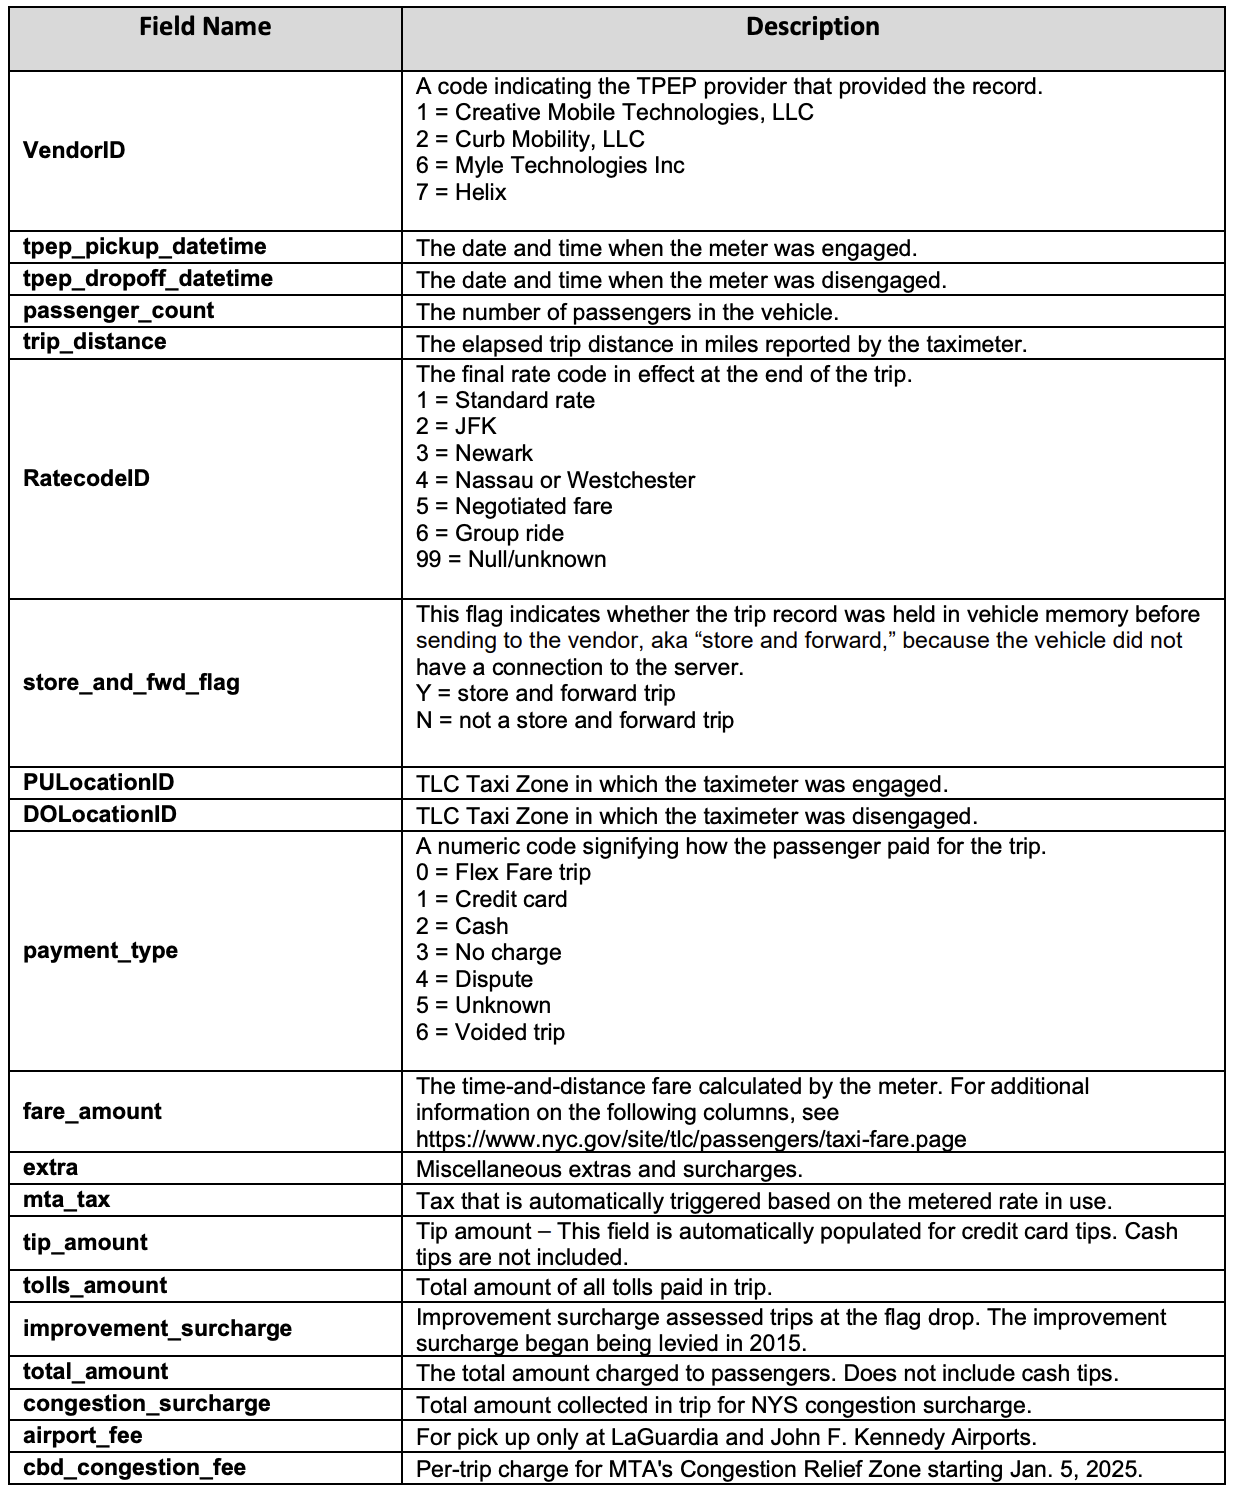

In [1]:
# %load nbheader.py
%reload_ext autoreload
%autoreload 2

from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.functions import col as S
from pyspark.sql import DataFrame, Row, Window
import os
import sys
import json
import datetime
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# spark = SparkSession.builder.master("local[4]").getOrCreate()
# spark.getActiveSession()
# spark.stop()



In [2]:
spark = SparkSession.builder \
    .master("local[4]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
spark.getActiveSession()
# spark.stop()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/24 18:53:31 WARN Utils: Your hostname, RCBM8368-DIII.local, resolves to a loopback address: 127.0.0.1; using 10.250.94.128 instead (on interface en0)
25/09/24 18:53:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/24 18:53:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# spark.stop()

In [ ]:
# %%sh
# mkdir -p data
# cd data

In [3]:
NYC_TRIP_DATA = 'data/yellow_tripdata_2025-08.parquet'
ZONE_DATA = 'data/taxi_zone_lookup.csv'

In [4]:
trip_df = spark.read.parquet(NYC_TRIP_DATA)
trip_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [5]:
trip_df.cache()
N_trip = trip_df.count()
print(f"Number of records: {N_trip:,}")

Number of records: 3,574,091


## Histogram
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.histogram_numeric.html


In [6]:
histogram_data = trip_df.select(F.histogram_numeric("trip_distance", F.lit(10)))
print(histogram_data)

DataFrame[histogram_numeric(trip_distance, 10): array<struct<x:double,y:double>>]


In [7]:
histogram_data.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|histogram_numeric(trip_distance, 10)                                                                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{3.7523223704514908, 3573969.0}, {25472.879999999997, 27.0}, {62043.57857142858, 14.0}, {92313.13764705883, 34.0}, {117976.57250000001, 20.0}, {138758.8588888889, 9.0}, {160633.04249999998, 8.0}, {205101.956, 5.0}, {240082.24, 1.0

In [8]:
histo_df = pd.DataFrame(histogram_data.collect()[0][0])
histo_df

,0,1
0,3.752322,3573969.0
1,25472.880000,27.0
2,62043.578571,14.0
3,92313.137647,34.0
4,117976.572500,20.0
5,138758.858889,9.0
6,160633.042500,8.0
7,205101.956000,5.0
8,240082.240000,1.0
9,268333.282500,4.0


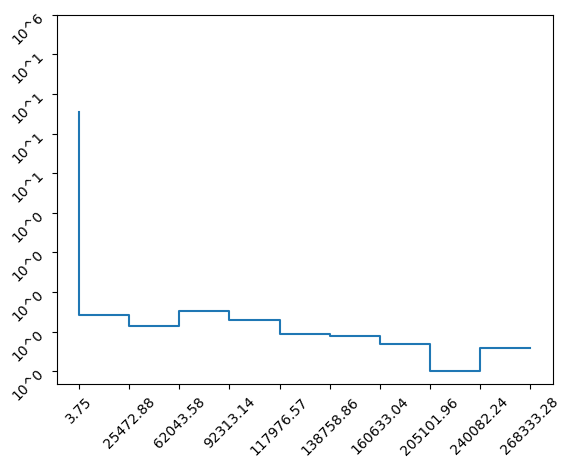

In [9]:
x = histo_df[0].values
y = histo_df[1].values
plt.step(range(len(y)), np.log10(y), where='pre')
plt.xticks(range(len(x)), [f"{xx:0.2f}" for xx in x], rotation=45)
plt.yticks(range(len(y)), [f"10^{int(yy)}" for yy in reversed(np.log10(y))], rotation=45)
plt.show()

**Pandas**

But we don't want to load the entire dataset into Pandas. We just take a random sample

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

Try smaller samples wtih different seeds...

Number of samples: 36,038


array([[<Axes: title={'center': 'trip_distance'}>]], dtype=object)

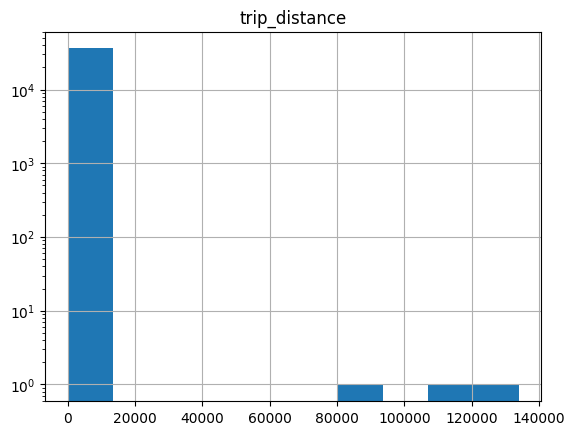

In [11]:
sample_trip_df = trip_df.sample(fraction=0.01, seed=42)
sample_trip_df.cache()
print(f"Number of samples: {sample_trip_df.count():,}")

sample_trip_df.toPandas().hist("trip_distance", bins=10, log=True)

25/09/24 19:11:35 WARN CacheManager: Asked to cache already cached data.


Number of samples: 36,038


array([[<Axes: title={'center': 'trip_distance'}>]], dtype=object)

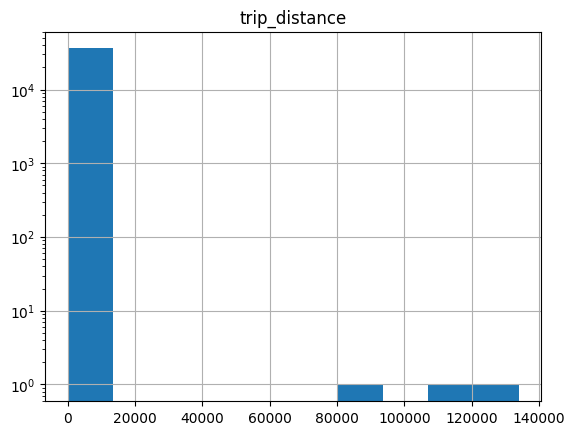

In [15]:
ample_trip_df = trip_df.sample(fraction=0.01, seed=17)
sample_trip_df.cache()
print(f"Number of samples: {sample_trip_df.count():,}")

sample_trip_df.toPandas().hist("trip_distance", bins=10, log=True)

In [ ]:
sample_trip_df.unpersist()
del sample_trip_df

**Zone Data**

In [ ]:
zone_df = spark.read.csv('data/taxi_zone_lookup.csv', header=True)
zone_df.printSchema()

In [ ]:
zone_df.cache()
N_zone = zone_df.count()
print(f"Number of zones: {N_zone:,}")
zone_df.limit(10).toPandas()

In [18]:
trip_df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
VendorID,3574091,1.8853224498201082,0.7160911723878136,1,7
passenger_count,2687857,1.3303784390315407,0.7628464379242123,0,9
trip_distance,3574091,7.089371546498481,665.3595265314826,0.0,274082.38
RatecodeID,2687857,3.6918831619390464,15.639513012712099,1,99
store_and_fwd_flag,2687857,None,None,N,Y
PULocationID,3574091,158.1166248984707,66.39681659817424,1,265
DOLocationID,3574091,157.81689050446673,71.03442901277467,1,265
payment_type,3574091,0.9608202477217284,0.8060937298554164,0,4
fare_amount,3574091,18.09525883924119,20.93935936802463,-1143.3,2092.5


# Example Top-earning Drivers 
Top-earning Drivers over Rolling Time Window. Calculate the total fare per driver (if available) or per VendorID over a rolling 7-day window.

In [19]:
# Convert pickup datetime to date for easier grouping
trip_df = trip_df.withColumn("pickup_date", F.to_date("tpep_pickup_datetime"))
trip_df = trip_df.withColumn("pickup_date_unix", F.unix_date("pickup_date"))
trip_df.printSchema()
trip_df \
    .where(S("VendorID")==F.lit(2)) \
    .groupBy("pickup_date", "pickup_date_unix") \
    .agg(F.count("VendorID").alias("n")) \
    .orderBy("pickup_date") \
    .limit(10).toPandas()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_date_unix: integer (nul

,pickup_date,pickup_date_unix,n
0,2009-01-01,14245,1
1,2025-07-31,20300,15
2,2025-08-01,20301,98980
3,2025-08-02,20302,105667
4,2025-08-03,20303,90538
5,2025-08-04,20304,82765
6,2025-08-05,20305,92868
7,2025-08-06,20306,100437
8,2025-08-07,20307,96352
9,2025-08-08,20308,92009


In [20]:
# Define window: partitioned by VendorID, ordered by pickup_date, with 6 preceding days
window_spec = Window.partitionBy("VendorID") \
    .orderBy(S("pickup_date_unix")) \
    .rangeBetween(-6, 0)

# Calculate rolling 7-day fare total per VendorID
trip_windowed_df = trip_df.withColumn(
    "rolling_7day_fare",
    F.sum("fare_amount").over(window_spec)
)

# Optionally: aggregate (one row per day/vendor) and display top earners
result = trip_windowed_df.select("VendorID", "pickup_date", "pickup_date_unix", "rolling_7day_fare") \
    .distinct() \
    .orderBy(S("rolling_7day_fare").desc())

# Show result
result.show(20)

result = result.withColumn("rolling_7day_fare_formatted", F.concat(F.lit("$"), F.format_number("rolling_7day_fare", 2)))
display(result.select("VendorID", S("pickup_date").alias("Date"), S("rolling_7day_fare_formatted").alias("7 Day Fare")).toPandas().head(10))

+--------+-----------+----------------+--------------------+
|VendorID|pickup_date|pickup_date_unix|   rolling_7day_fare|
+--------+-----------+----------------+--------------------+
|       2| 2025-08-07|           20307|1.2084925729999885E7|
|       2| 2025-08-17|           20317|1.1992097890000038E7|
|       2| 2025-08-31|           20331| 1.197013195000055E7|
|       2| 2025-08-08|           20308|1.1912238210000014E7|
|       2| 2025-08-16|           20316|1.1860498270000001E7|
|       2| 2025-08-30|           20330|1.1848476310000213E7|
|       2| 2025-08-18|           20318|1.1752510820000086E7|
|       2| 2025-08-15|           20315|1.1750684540000033E7|
|       2| 2025-08-14|           20314|1.1692139050000131E7|
|       2| 2025-08-09|           20309|1.1666844680000316E7|
|       2| 2025-08-13|           20313|1.1640049980000213E7|
|       2| 2025-08-10|           20310| 1.163379641000065E7|
|       2| 2025-08-11|           20311|1.1572704360000208E7|
|       2| 2025-08-12|  

,VendorID,Date,7 Day Fare
0,2,2025-08-07,"$12,084,925.73"
1,2,2025-08-17,"$11,992,097.89"
2,2,2025-08-31,"$11,970,131.95"
3,2,2025-08-08,"$11,912,238.21"
4,2,2025-08-16,"$11,860,498.27"
5,2,2025-08-30,"$11,848,476.31"
6,2,2025-08-18,"$11,752,510.82"
7,2,2025-08-15,"$11,750,684.54"
8,2,2025-08-14,"$11,692,139.05"
9,2,2025-08-09,"$11,666,844.68"


# Predict Tips

Build a regression model to predict how much a passenger would tip.

Using https://spark.apache.org/docs/latest/ml-classification-regression.html


### Available Regression Algorithms in PySpark ML

- **Linear Regression**
  - Includes variants: ordinary least squares, Lasso (L1 regularization), Ridge (L2 regularization), and Elastic Net.
  - https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html

- **Decision Tree Regression**
  - Handles non-linear relationships and can model complex patterns without explicit feature transforms.
  - https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.DecisionTreeRegressor.html

- **Random Forest Regression**
  - An ensemble of decision trees, offering improved accuracy and robustness against overfitting.
  - https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html

- **Gradient-Boosted Tree (GBT) Regression**
  - Builds trees sequentially to correct errors from previous models, providing strong predictive performance for structured data.
  - https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html


In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [21]:
# Prepare data: select the relevant columns and drop any missing values
features = ['trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount']
data_clean = trip_df \
    .where("payment_type = 1") \
    .select(features + ['tip_amount']).dropna()
print(F"Number of records: {data_clean.count():,}")

Number of records: 2,182,738


In [24]:
# Cast location IDs to numeric if necessary
data_clean = data_clean.withColumn('PULocationID', S('PULocationID').cast('double'))
data_clean = data_clean.withColumn('DOLocationID', S('DOLocationID').cast('double'))

### Create Feature Vector
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html

In [27]:

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol='features')
data_vector = assembler.transform(data_clean)

# Select features and label
final_data = data_vector.select('features', 'tip_amount')
final_data.printSchema()
final_data.show(3)

root
 |-- features: vector (nullable = true)
 |-- tip_amount: double (nullable = true)

+--------------------+----------+
|            features|tip_amount|
+--------------------+----------+
|[8.44,138.0,141.0...|       5.0|
|[4.98,138.0,193.0...|       0.0|
|[1.89,249.0,45.0,...|      3.99|
+--------------------+----------+
only showing top 3 rows


In [28]:
# Split into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

### Model

In [29]:
# Build and fit the regression model
lr = LinearRegression(labelCol='tip_amount', featuresCol='features', regParam=0.01)
model = lr.fit(train_data)

25/09/24 19:40:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/09/24 19:40:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [30]:
# Generate predictions
predictions = model.transform(test_data)
predictions.select('features', 'tip_amount', 'prediction').show(10)

+------------------+----------+------------------+
|          features|tip_amount|        prediction|
+------------------+----------+------------------+
|[0.0,1.0,1.0,10.0]|       0.0|2.4078180693304896|
|[0.0,1.0,1.0,24.0]|       0.0| 4.319314999495231|
|[0.0,1.0,1.0,24.0]|      6.25| 4.319314999495231|
|[0.0,1.0,1.0,29.0]|       0.0| 5.001992474554067|
|[0.0,1.0,1.0,30.0]|       0.0| 5.138527969565834|
|[0.0,1.0,1.0,30.0]|       0.0| 5.138527969565834|
|[0.0,1.0,1.0,49.0]|       0.0| 7.732702374789412|
|[0.0,1.0,1.0,59.0]|       0.0| 9.098057324907083|
|[0.0,1.0,1.0,84.6]|      10.0|12.593365997208323|
|[0.0,1.0,1.0,85.0]|       0.0| 12.64798019521303|
+------------------+----------+------------------+
only showing top 10 rows


### Evaluation

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate MAE
mae_evaluator = RegressionEvaluator(
    labelCol='tip_amount',
    predictionCol='prediction',
    metricName='mae'
)
mae = mae_evaluator.evaluate(predictions)

# Evaluate R-squared
r2_evaluator = RegressionEvaluator(
    labelCol='tip_amount',
    predictionCol='prediction',
    metricName='r2'
)
r2 = r2_evaluator.evaluate(predictions)

print("MAE:", mae)
print("R-squared:", r2)

MAE: 1.774495979709592
R-squared: 0.4312867229876808


In [32]:
mape_df = predictions.withColumn(
    'ape',
    F.when(S('tip_amount') > F.lit(0.0), F.abs((S('prediction') - S('tip_amount')) / S('tip_amount')))
)
mape = mape_df.select(F.mean(S('ape'))).collect()[0][0]
print("MAPE:", mape)

MAPE: 1.3516268629581893


In [ ]:
# 

In [35]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [36]:
# Define feature columns (remove columns with direct leakage to tip, e.g., total_amount)
feature_cols = [
    "VendorID", "passenger_count", "trip_distance", "RatecodeID", 
    "store_and_fwd_flag", "PULocationID", "DOLocationID", "fare_amount", "extra",
    "mta_tax", "tolls_amount", "improvement_surcharge", "congestion_surcharge",
    "Airport_fee", "cbd_congestion_fee"
]

indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_flag_idx")
assembler_input = [col if col != "store_and_fwd_flag" else "store_and_fwd_flag_idx" for col in feature_cols]
assembler = VectorAssembler(inputCols=assembler_input, outputCol="features")


In [37]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol='features',
    labelCol='tip_amount',
    numTrees=50
)


In [38]:
df_cc = trip_df.filter(trip_df.payment_type == 1)
df_cc.count()


2182738

In [39]:
pipeline = Pipeline(stages=[indexer, assembler, rf])
model = pipeline.fit(df_cc)


In [40]:
predictions = model.transform(df_cc)

# Feature importances are from the final stage (Random Forest)
rf_model = model.stages[-1]
importances = rf_model.featureImportances

# Display feature importances
feature_names = assembler.getInputCols()
for fname, score in zip(feature_names, importances):
    print(f"{fname}: {score:.4f}")

VendorID: 0.0149
passenger_count: 0.0000
trip_distance: 0.2008
RatecodeID: 0.0717
store_and_fwd_flag_idx: 0.0000
PULocationID: 0.0022
DOLocationID: 0.0023
fare_amount: 0.3802
extra: 0.0324
mta_tax: 0.0115
tolls_amount: 0.1146
improvement_surcharge: 0.0616
congestion_surcharge: 0.0041
Airport_fee: 0.0987
cbd_congestion_fee: 0.0048


In [ ]:
feature_names

In [43]:
importances.values

array([1.49358857e-02, 3.04233909e-05, 2.00759442e-01, 7.17366080e-02,
       1.10699049e-06, 2.20235077e-03, 2.33952687e-03, 3.80229314e-01,
       3.24165845e-02, 1.15282988e-02, 1.14614854e-01, 6.15508901e-02,
       4.11319161e-03, 9.86944772e-02, 4.84704658e-03])

In [44]:
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances.values}) \
    .sort_values("importance", ascending=False)
display(feature_importance)

,feature,importance
7,fare_amount,0.380229
2,trip_distance,0.200759
10,tolls_amount,0.114615
13,Airport_fee,0.098694
3,RatecodeID,0.071737
11,improvement_surcharge,0.061551
8,extra,0.032417
0,VendorID,0.014936
9,mta_tax,0.011528
14,cbd_congestion_fee,0.004847


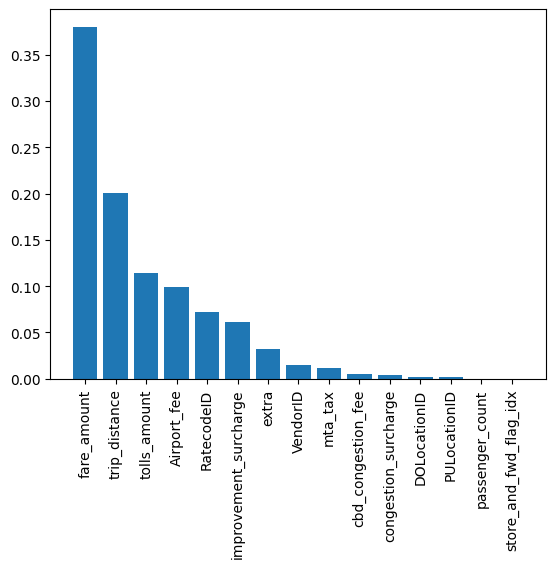

In [45]:
plt.bar(range(feature_importance.shape[0]), feature_importance.importance)
plt.xticks(range(feature_importance.shape[0]), feature_importance.feature, rotation=90)
plt.show()